In [27]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [28]:
!ollama list

NAME                       ID              SIZE      MODIFIED   
nomic-embed-text:latest    0a109f422b47    274 MB    4 days ago    
llama3.2-vision:latest     085a1fdae525    7.9 GB    6 days ago    
phi3:latest                4f2222927938    2.2 GB    7 days ago    
gemma2:2b                  8ccf136fdd52    1.6 GB    7 days ago    
llama3.2:latest            a80c4f17acd5    2.0 GB    7 days ago    
phi3:medium                cf611a26b048    7.9 GB    7 days ago    
llama3.1:latest            46e0c10c039e    4.9 GB    7 days ago    
mistral:latest             f974a74358d6    4.1 GB    7 days ago    


In [29]:
EMBEDDING_MODEL = "nomic-embed-text"
LLM_MODEL = "llama3.2"

In [30]:
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings

llm = ChatOllama(model=LLM_MODEL, temperature=0)

embedding = OllamaEmbeddings(model=EMBEDDING_MODEL)

#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

In [31]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=50)

splits = text_splitter.split_documents(blog_docs)

In [32]:
import chromadb

chroma_client = chromadb.Client()
collections = chroma_client.list_collections()

collections

# chroma_client = delete_collection("langchain")
# chroma_client.list_collections()

[Collection(name=langchain)]

In [39]:
# from langchain_community.vectorstores import Chroma

# # Embed
# vectorstore = Chroma.from_documents(
#     persist_directory="./chroma_db",
#     documents=splits,
#     embedding=OllamaEmbeddings(
#         model=EMBEDDING_MODEL
#     )
# )

# retriever = vectorstore.as_retriever()

In [40]:
# Embed
vectorstore = Chroma(
    persist_directory="./chroma_db",
    embedding_function=embedding
)

retriever = vectorstore.as_retriever()

# Query Translation

Distance-based vector database retrieval embeds queries in high-dimensional space and finds similar embedded documents based on a distance metric.

But, retrieval may produce different results with subtle changes in query wording, or if the embeddings do not capture the semantics of the data well. Prompt engineering / tuning is sometimes done to manually address these problems, but can be tedious.

## Multi Query Retrieval

Using an LLM to generate multiple queries from different perspectives for a given user input query.

### Prompt

In [46]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate exactly five 
different versions of the given user question to retrieve relevant documents from a vector 
database. Provide these alternative questions as a plain list without any introductory text 
or numbering. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

In [47]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [48]:
docs = generate_queries.invoke({"question":question})
len(docs)

5

In [49]:
docs

['What is the concept of task decomposition in Large Language Model (LLM) agents?',
 'How does task decomposition work for LLM agents?',
 'What are the benefits of using task decomposition with LLM agents?',
 'Can you explain the process of task decomposition for LLM agents?',
 'How does task decomposition improve the performance of LLM agents?']

In [50]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

5

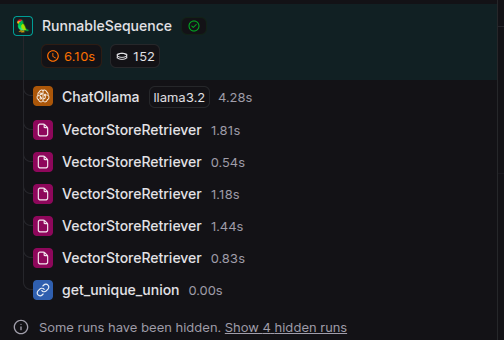

In [51]:
from operator import itemgetter
from langchain_ollama import ChatOllama
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'According to the text, task decomposition for LLM (Large Language Model) agents involves breaking down large tasks into smaller, manageable subgoals. This can be done in three ways:\n\n1. Using simple prompting, such as "Steps for XYZ. 1.", or "What are the subgoals for achieving XYZ?"\n2. Using task-specific instructions, such as "Write a story outline." for writing a novel\n3. With human inputs.\n\nTask decomposition is used to enable efficient handling of complex tasks and allows the LLM agent to plan ahead and make progress towards its goals.'

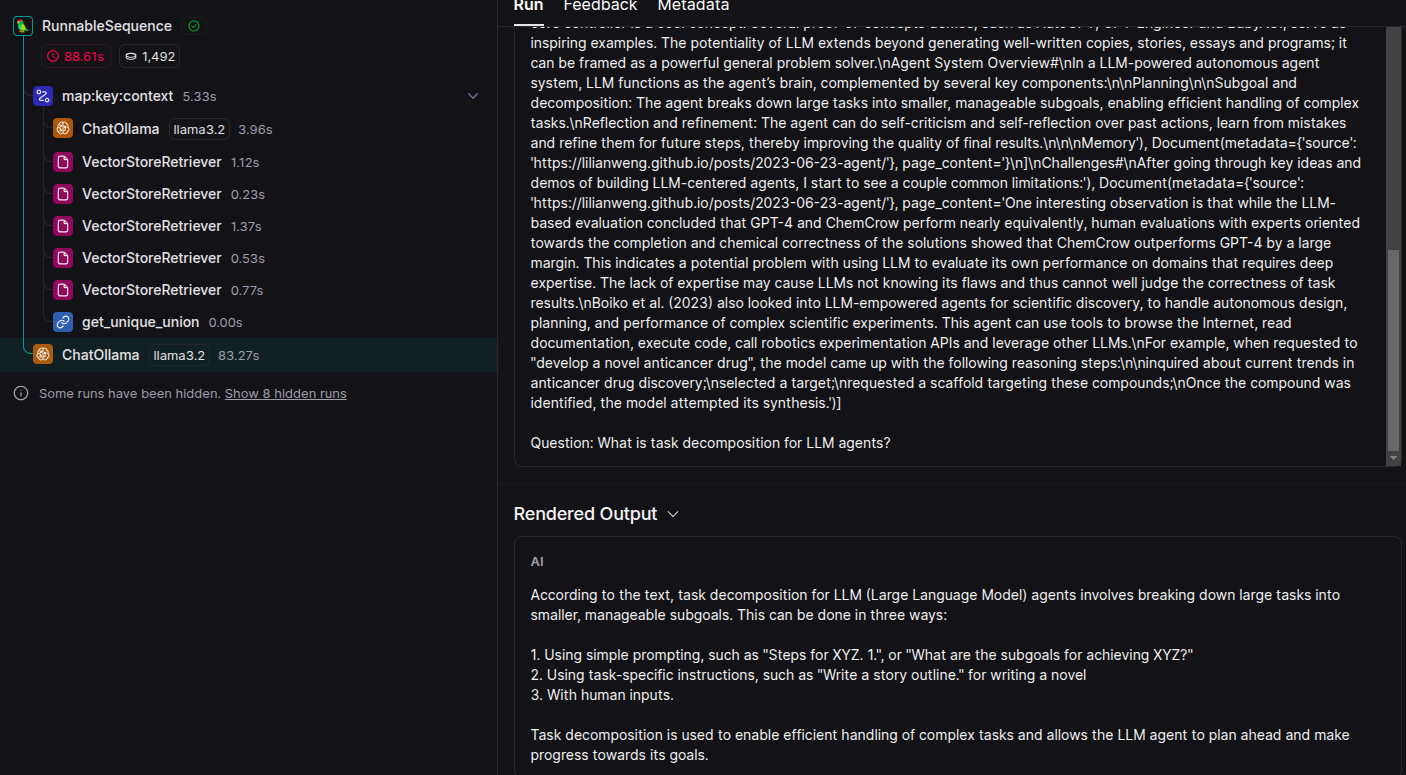